# Section 07
In this exercise some thermodynamical properties ($U/N$ and $p$) of a monoatomic Lennard-Jones system in gas, liquid and solid phases will be studied. Molecular Dynamics (MD) and Monte Carlo (MC) approaches will be used respectively with microcanonical and canonical ensambles.

[**MD**]
In the MD approach particles' positions and velocities are updated using the Verlet integration algorithm with a provided time step $\delta^{(phase)}_t=5 \times 10^{-4}$, which ensures that $E$ remains (almost) constant.

[**MC**]
In the MC approach particles' positions are sampled using the Metropolis algorithm to sample from the positions probability distribution. At each step we try to displace a number of uniformly sampled particles, one at a time, by at most a provided $\delta^{(phase)}_x$.

The systems at study consist of 108 identical monoatomic particles starting from an fcc configuration constrained by the following properties:
|        | $T^\star$ | $\rho^\star$ | $r_c^\star$ |
|--------|-----------|--------------|-------------|
| gas    | 1.2       | 0.05         | 5.0         | 
| liquid | 1.1       | 0.8          | 2.5         |
| solid  | 0.8       | 1.1          | 2.2         |

The $\star$ apex points out that the value is expressed in reduced units.

In [1]:
# Importing project specific variables and utilities,
# like the executables' paths
from ex07.compute import *
from ex07.plot import *
from ex07.data import *
from ex07.paths import *
from global_utils import *
import os
from itertools import count

# using multiprocess instead of the standard library's multiprocessing
# as the latter doesn't work with jupyter notebooks
import multiprocess as mp
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme("notebook", "whitegrid", rc={
              "figure.dpi": 150, "ytick.minor.visible": True})

# Maximum number of processes for parallel execution
PROCESSES = max(os.cpu_count() - 1, 1)

SECTION = "07"
VARIABLES = ["U/N", "K/N", "E/N", "T", "p"]
PHASES = ["gas", "liquid", "solid"]

USE_CACHED = False


## Exercise 07.2
This section aims at assessing the block sizes that should be used in the estimation of the thermodynamical properties when using the Metropolis MC sampler, to deal with the effects of autocorrelation typical of that method.
### Strategy
The task is performed in four steps:
- system equilibration;
- instantaneous values gathering;
- autocorrelation functions computation;
- autocorrelation time evaluation.

At last the behaviour of the statistical uncertainty as a function of the block size will be assessed.

#### System equilibration
Equilibration is performed for each phase using 2500 steps. $\delta^{(phase)\star}_x$ is tuned to provide an acceptance rate of $\approx 50\%$.

Here and in the following section we found that proper values are:
|                  | gas  | liquid | solid  |
|------------------|------|--------|--------|
| $\delta_x^\star$ | 13.0 | 0.2052 | 0.1153 |

In [2]:
EXERCISE = SECTION + "_2"

# equilibration

# launching the equilibration for each phase in a different process in parallel
with mp.Pool(PROCESSES) as pool:
    res = list(pool.map(
        lambda args: equilibrate_07_2(phase=args[0], p_line=args[1], use_cached=USE_CACHED), zip(PHASES, count(0,2))))
for r, phase in zip(res, PHASES):
    print(f"{phase} acceptance rate: {r.stdout.decode()}")


gas acceptance rate: 0.613904
liquid acceptance rate: 0.503307
solid acceptance rate: 0.488867


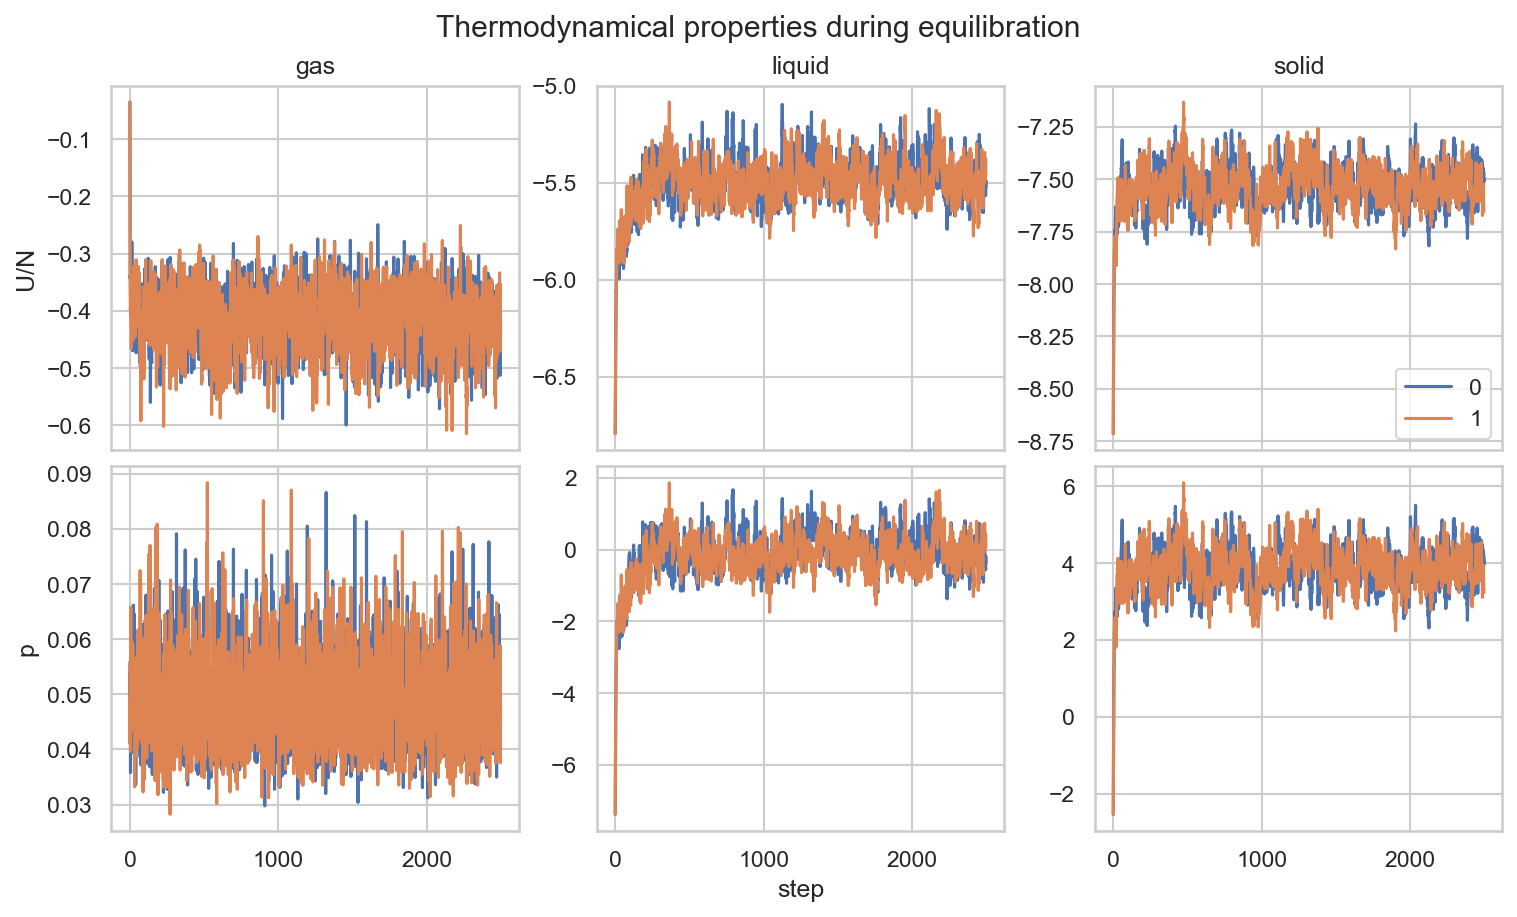

In [3]:
# Plotting the equilibration results for the internal energy and pressure.
# Two runs are executed for each variable/phase

# Results
dfss = [read_equilibration_07_2(phase) for phase in PHASES]

# Plotting
fig, axes = plt.subplots(2, 3, figsize=(
    10, 6), constrained_layout=True, sharex=True)
for dfs, axs, phase in zip(dfss, axes.transpose(), PHASES):
    for ax, var in zip(axs, ["U/N", "p"]):
        for i, df in enumerate(dfs):
            ax.plot(var, data=df, label=f"{i}")
axes[0, 0].set_ylabel("U/N")
axes[1, 0].set_ylabel("p")
axes[1, 1].set_xlabel("step")
for phase, ax in zip(PHASES, axes[0, :]):
    ax.set_title(phase)
ax.legend()
_ = fig.suptitle("Thermodynamical properties during equilibration")

The systems were equilibrated.

#### Instantaneous values gathering
Starting from the configuration reached during the equilibration phase, $5 \times 10^5$ more configurations are sampled using MC.

In [4]:
# set USE_CACHED to False to recompute
with mp.Pool(PROCESSES) as pool:
    # launching the measurements
    # the executable prints out the acceptance rates
    res = list(pool.map(
        lambda args: run_07_2(phase=args[0], p_line=args[1], use_cached=USE_CACHED), zip(PHASES, count(0))))
for r, phase in zip(res, PHASES):
    print(f"{phase} acceptance rate: {r.stdout.decode()}")
# collecting the computed internal energy data
data = {phase: read_measures_07_2(phase)["U/N"] for phase in PHASES}


gas acceptance rate: 0.614751
liquid acceptance rate: 0.499973
solid acceptance rate: 0.489067


#### Autocorrelation functions
For each series of energies the autocorrelation function is computed for 0 to 100 step lags, which are enough to get a sense of the autocorrelation time's order of magnitude.

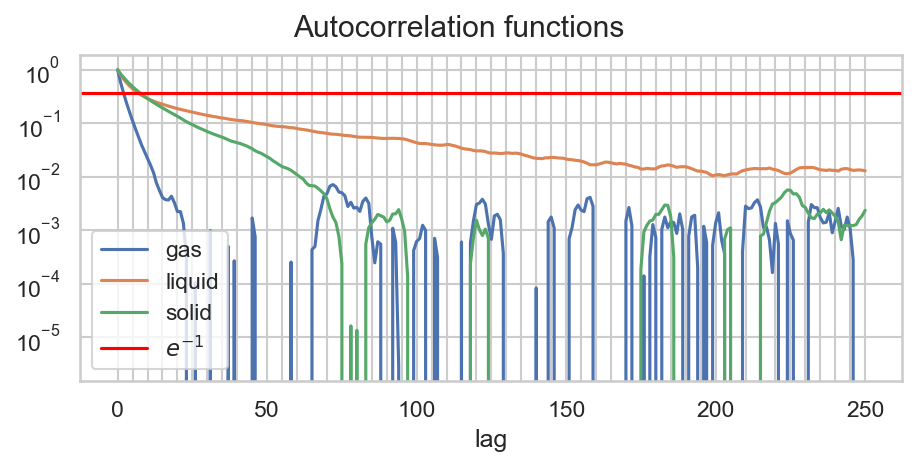

In [5]:
# Computing and plotting the autocorrelation functions.
# exp{-1} is also plotted for comparison.
acfns, fig, ax = plot_autocorrs(data, nlags=250, figsize=(6, 3))
ax.set_xticks(np.arange(0, 250, 5), minor=True)
ax.grid(True, which="both", axis="x")
# The logarithmic scale aids in appreciating the autocorrelation trends.
ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel("lag");

From the figure we can deduce that the orders of magnitude of the autocorrelation times ($t_c$) are $10^0$-$10^1$.

#### Statistical uncertainty vs block size
The statistical uncertainty will be computed for many block sizes and its trend will be displayed. Such plot should help in determining the proper block size to use during measurements.

Autocorrelation times are also plotted for comparison.

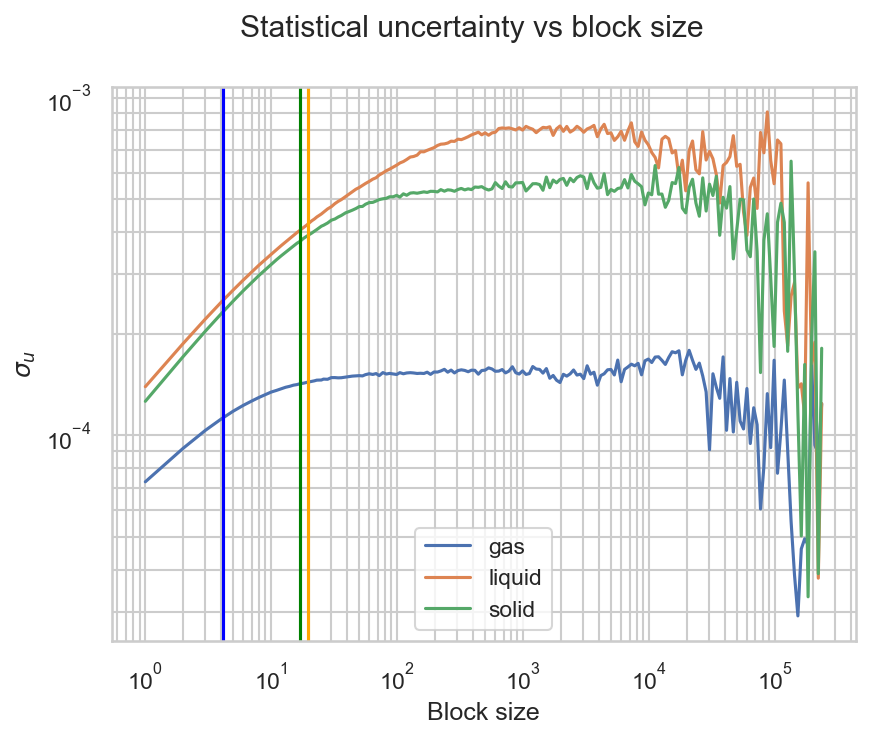

In [6]:
# Estimating the correlation times as least-squares fits of exponential decays
t_cs = [estimate_tc(acfn, 10.0, bounds=(1.0, 50.0)) for acfn in acfns]

# Block sizes ranging logarithmically from 1 to (5*10^5 / 2)
blk_sizes = np.logspace(0, np.log10(500000/2), 200, base=int(10), dtype="int", endpoint=False)

# Computing the uncertainty for every phase and block size
uncerts = pd.DataFrame.from_dict({
    phase: [block_uncert(u_series, blk_size) for blk_size in blk_sizes]
    for phase, u_series in data.items()
})
uncerts.index = pd.Index(blk_sizes, dtype="int", name="Block size")
# Plotting uncertainties...
ax = uncerts.plot(legend=True)
# ...and correlation times (doubled, as that should provide a better estimation of the block size)
for (t_c, _), c in zip(t_cs, ["blue", "orange", "green"]):
    ax.axvline(2*t_c, c=c)
# Using a logarithmic scale on both axes
ax.loglog()
ax.grid(visible=True, which="both")
ax.set_ylabel(r"$\sigma_u$")
_ = ax.figure.suptitle("Statistical uncertainty vs block size")


Upon reaching a certain block size the uncertainty saturates. Double the fitted correlation times do not point to such situation though.

## Exercise 07.4
 Thermodynamic analysis performed under NVE and NVT assumptions using respectively dynamical evolution (MD) and stochastic sampling (MC) will be compared.

 The discretized radial distribution function for each system will be displayed.
 
 ### Strategy
 1. Equilibration;
 1. measures;
 1. comparison.


#### Equilibration
Equilibration is performed using the following number of steps:
|        | MC    | MD     |
|--------|-------|--------|
| gas    | 15000 | 750000 |
| liquid | 15000 | 50000  |
| solid  | 15000 | 75000  |

These values were chosen taking 50 times the lag which produces an autocorrelation of less than $e^{-4}$ except for gas MD, where the condition is relaxed to $e^{-3}$. It was seen that these conditions produce satisfactory results both in terms of having low autocorrelation and reasonable run times.

As the algorithm doesn't preserve temperature before reaching equilibrium, the MD equilibrations were started from the following configurations:
|           | gas  | liquid | solid |
|-----------|------|--------|-------|
| $T^\star$ | 0.95 | 1.988  | 1.545 |

In [7]:
# equilibration
if not USE_CACHED:
    with mp.Pool(PROCESSES) as pool:
        res = list(pool.map(lambda args: equilibrate_07_4(
            phase=args[0], p_line=args[1], samplers=["mc", "md"]), zip(PHASES, range(3))))
        for r, phase in zip(res, PHASES):
            print(f"{phase} acceptance rate: {float(r.stdout.decode()):.2g}")
else:
    # rs were manually copied from the last run
    for r, phase in zip([0.61, 0.5, 0.49], PHASES):
        print(f"{phase} acceptance rate: {r:.2g}")


gas acceptance rate: 0.61
liquid acceptance rate: 0.5
solid acceptance rate: 0.49


#### Measures
Measures were taken using as block size 1/50 the equilibration times reported above for 200 blocks.

In [8]:
# measures
if not USE_CACHED:
    with mp.Pool(PROCESSES) as pool:
        res = list(
            pool.map(lambda args: run_07_4(phase=args[0],
                                           n_bins=51,
                                           p_line=args[1],
                                           samplers=["mc", "md"],
                                           start_from="warmup"),
                     zip(PHASES, count(0)))
        )


#### Comparison

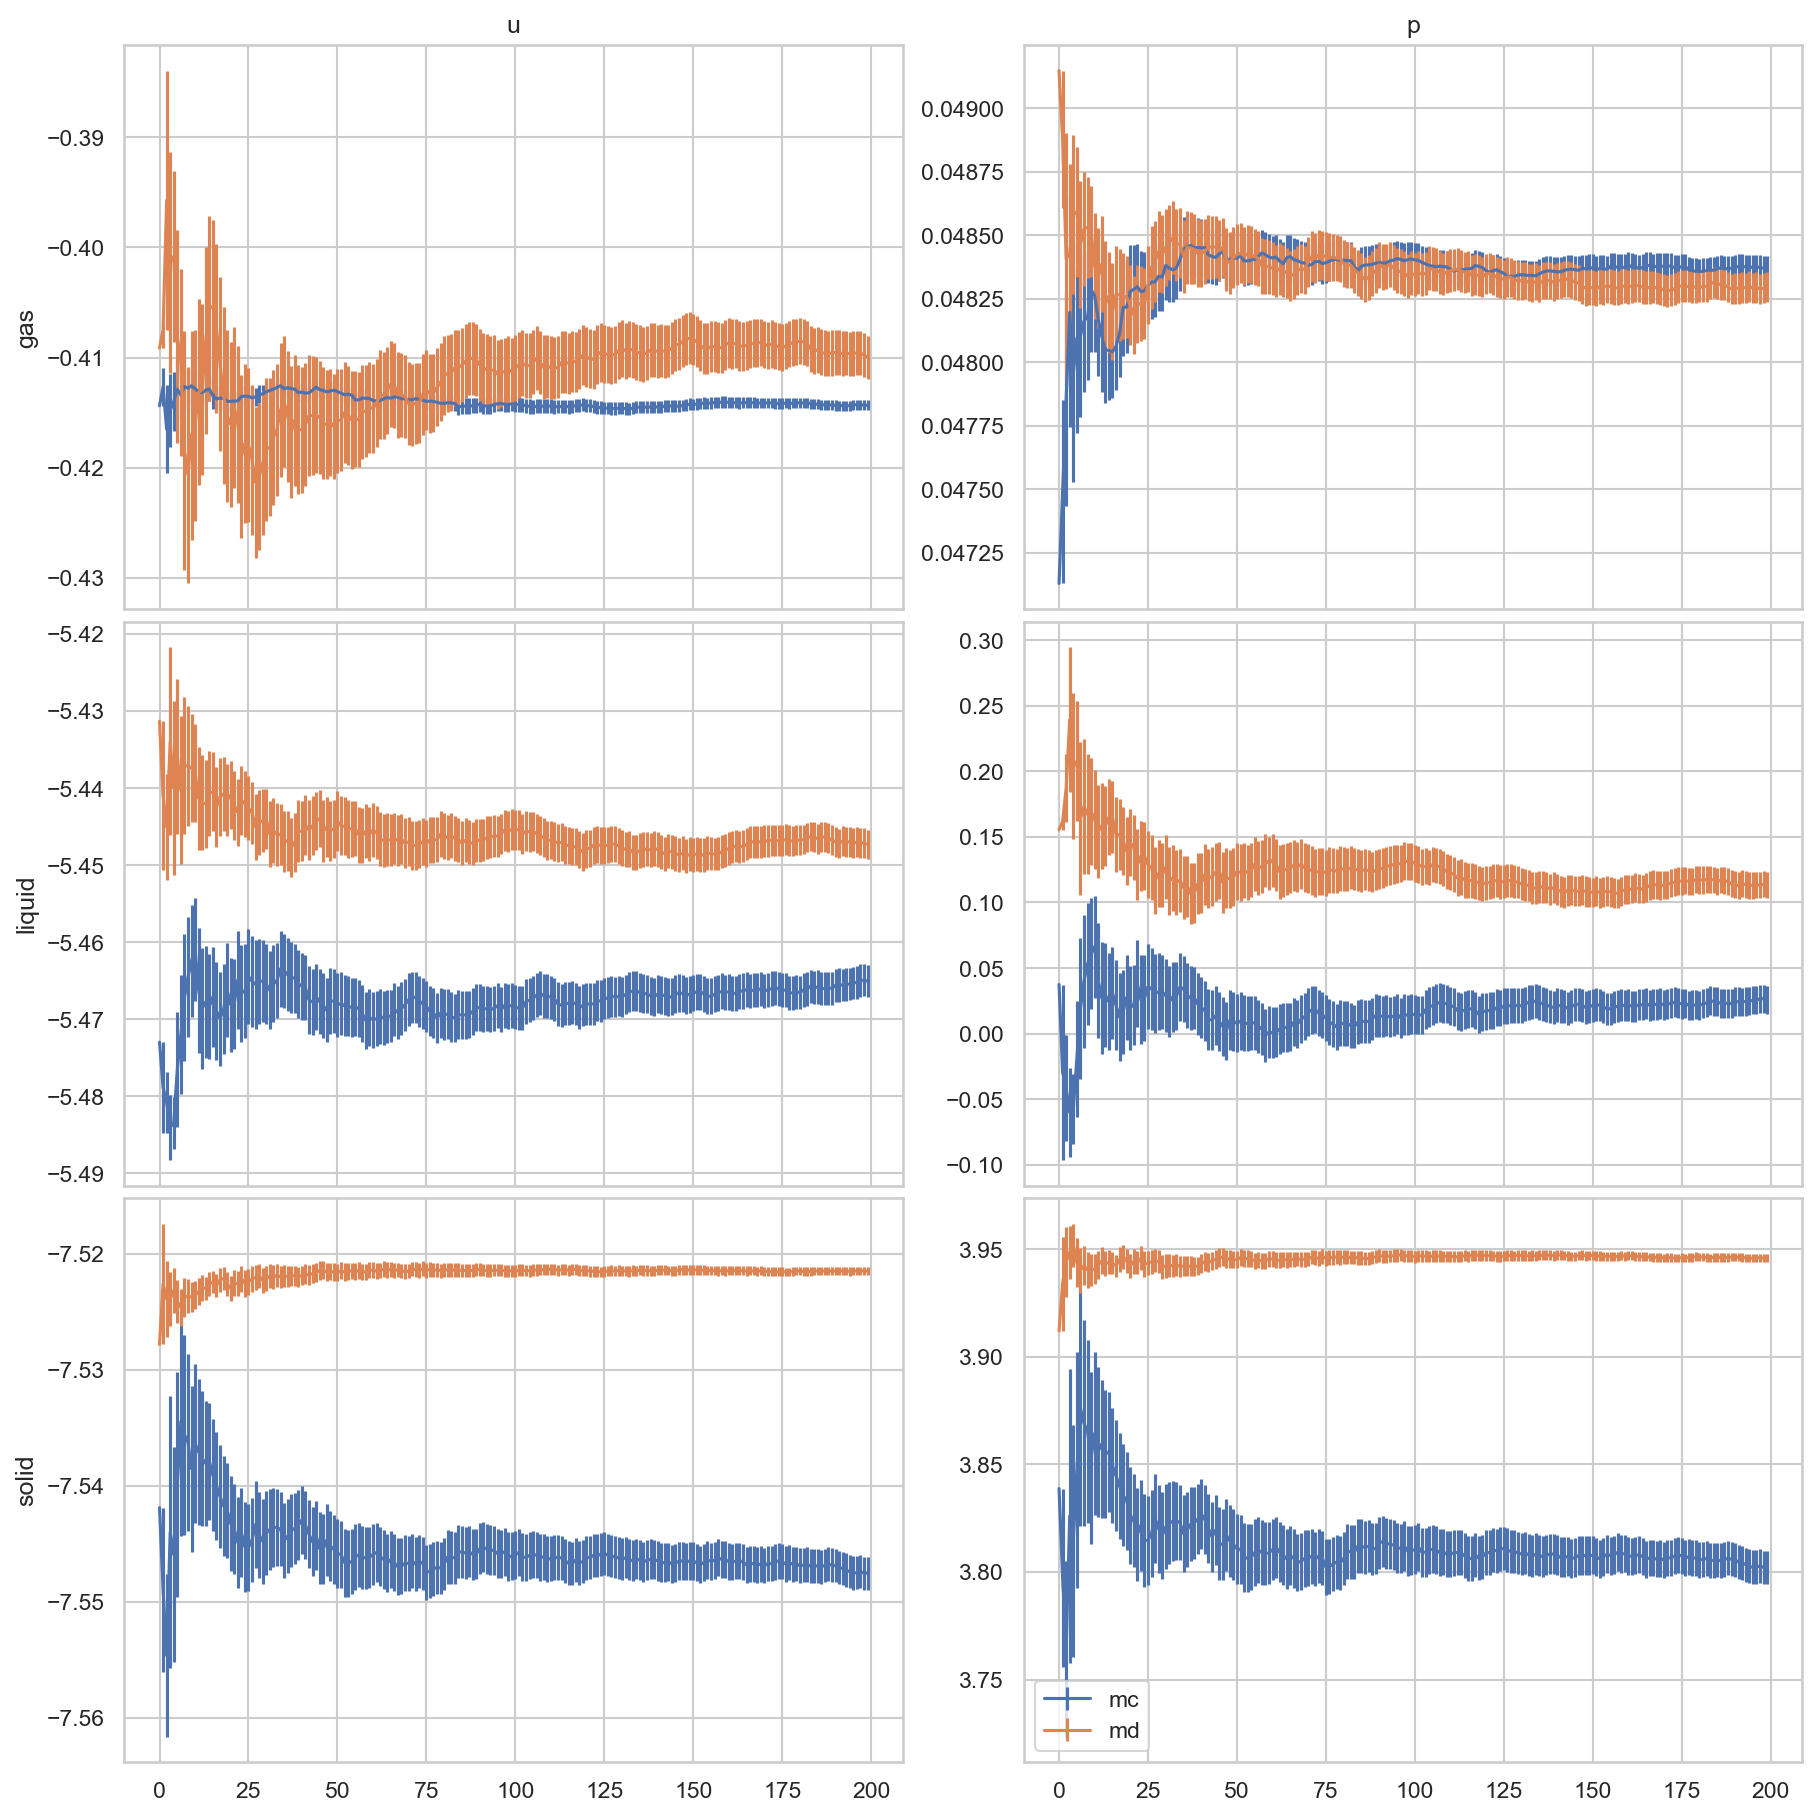

In [9]:
# Plotting energy and pressure measurement results
VARIABLES = ["u", "p"]
fig, axes = plt.subplots(3, len(VARIABLES), figsize=(
    6*len(VARIABLES), 4*3), constrained_layout=True, sharex=True)

for phase, axs in zip(PHASES, axes):
    # reading measures
    dfs = {method: read_measures_07_4(phase, method)[0]
           for method in ["mc", "md"]}
    for var, ax in zip(VARIABLES, axs):
        for method, df in dfs.items():
            # plot
            ax.errorbar(
                x="index", y=f"{var}_mean", yerr=f"{var}_error", data=df.reset_index(drop=False), label=method)
    axs[0].set_ylabel(phase)
ax.legend()
axes[0, 0].set_title("u")
axes[0, 1].set_title("p");


The algorithms produce similar (although in most of the cases incompatible) results up to the first or second significant digit.

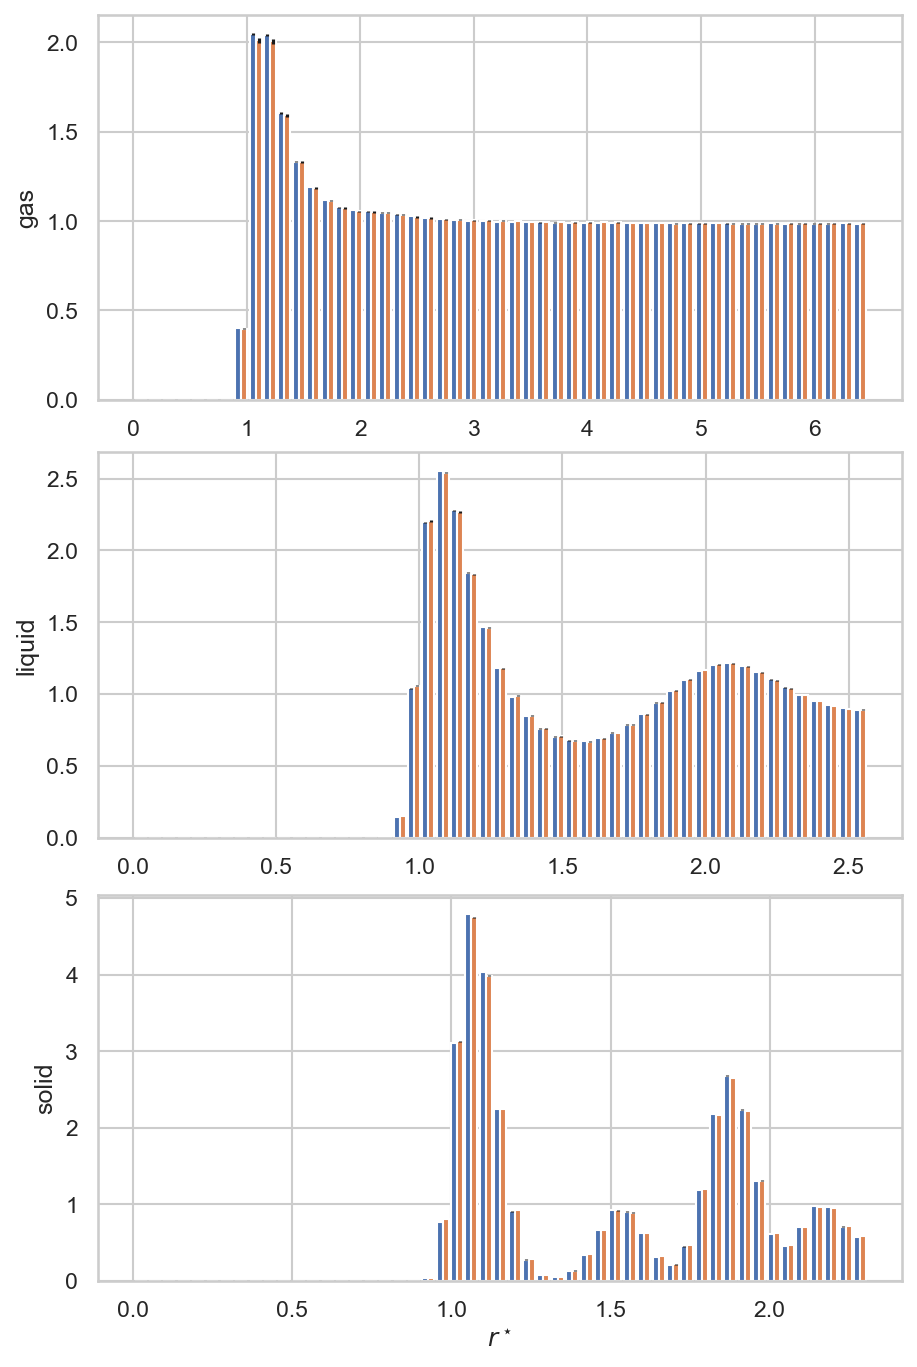

In [10]:
# Plotting radial distributions
fig, axes = plt.subplots(len(PHASES), 1, figsize=(
    6, 3*len(PHASES)), constrained_layout=True)

for phase, ax in zip(PHASES, axes):
    # reading radial data
    mc_df = read_measures_07_4(phase, "mc")[1]
    md_df = read_measures_07_4(phase, "md")[1]
    index = mc_df["r"]
    off = 5*index[1] / 12
    # Centering the bars in the middle of each interval
    ax.bar(mc_df["r"] + index[1]/2 - off/2, "g_mean", yerr="g_error", width=off,
           data=mc_df.reset_index(drop=False), align="center")
    ax.bar(md_df["r"] + index[1]/2 + off/2, "g_mean", yerr="g_error", width=off,
           data=md_df.reset_index(drop=False), align="center")
    ax.set_ylabel(phase)
ax.set_xlabel(r"$r^\star$");


The results produced by the two algorithms are very similar, although not always compatible given the statistical uncertainty.